# Trading Strategy Development & Testing 

**Goals**

1. Rigorous backtesting framework that avoids **LOOKAHEAD BIAS** and is more sophisticated than just using a simple/elementary train/test split 
2. Develop the following trading strategies: 
   1. Dynamic hedging trading strategies, either or both of: 
      1. Short term mean-reverting signals 
      2. Non-parametric rolling OLS estimation, which enables me to learn about: 
   2. LOB data 
   3. Risk management 
      1. Stop-loss
      2. Momentum filters 
      3. Managing regime changes/structural breaks/volatility 
3. Test realistically on out-of-sample data and compare to a benchmark 

In [2]:
import lakeapi 
import datetime as dt
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly
import plotly.graph_objects as go 
import numpy as np
from itertools import combinations

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import nolds
pd.set_option('display.max_rows', 100)

/Users/vivbear/Documents/Quant_Research/Projects/venv/lib/python3.13/site-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Helper Functions 

In [3]:
def make_prices_by_column(df: pd.DataFrame, value_column = 'str'):
    non_null_df = df[df['symbol'].notna()]
    prices_df = non_null_df.pivot(columns = 'symbol', values = value_column)
    #reindex prices 
    start = prices_df.index.min()
    end = prices_df.index.max()
    complete_index = pd.date_range(start=start, end=end, freq='10s')
    prices_df = prices_df.reindex(complete_index)
    #Reporting 
    num_null_by_symbol = prices_df.isna().sum()
    print(f"Amount of missing data by symbol, {num_null_by_symbol/len(prices_df)}")
    return prices_df

In [4]:
from typing import Literal
def summary_streaks_seconds(series, seconds_per_row = 10, stat: Literal['longest_location', 'describe'] = 'describe'):
    # Create groups of consecutive NaNs
    isnan = series.isna()
    flipped = ~isnan
    streak_counts = flipped.cumsum() #if we are detecting strings of consecutive trues, then flipping it and then doing a cum sum means that the now consecutive falses generate streak of all the same number 
    streak_groups = streak_counts[isnan]
    streak_counts = streak_groups.value_counts() #in terms of number of rows 
    if stat == 'describe': 
        summary = streak_counts.describe(percentiles=[0.25, 0.75, .90, .95, 0.99])
        return summary*seconds_per_row
    elif stat == 'longest_location':
        # Find the longest streak
        longest_streak_id = streak_counts.idxmax()
        # Find where this streak starts (first occurrence of this streak_id)
        longest_streak_indices = streak_groups[streak_groups == longest_streak_id].index
        return longest_streak_indices[0], longest_streak_indices[-1]

In [5]:
import statsmodels.api as sm 
def fit_spread(y: pd.Series, x: pd.Series) -> pd.Series: 
    x_with_constant = sm.add_constant(x)
    results = sm.OLS(y, x_with_constant, missing='drop').fit()  # ← Add this
    b0, b1 = results.params 
    spread = (y - (b0 + b1*x))
    return spread

# Data Processing 

In [6]:
resampled_df = pd.read_parquet('level1crypto_raw_origin_times_resampled.parquet')

In [6]:
resampled_df.index.min()
resampled_df.index.max()

Timestamp('2024-11-26 00:00:00')

Timestamp('2025-12-03 23:59:50')

In [9]:
TEST_CUTOFF = dt.datetime(2025, 9, 1)
train_df, test_df = resampled_df[resampled_df.index < TEST_CUTOFF], resampled_df[resampled_df.index >=TEST_CUTOFF]

# Data Processing - Missing Data 

## Test Data 

In [10]:
midprice_test_df = make_prices_by_column(test_df, value_column= 'mid_price')

Amount of missing data by symbol, symbol
BTC-USDT     0.038478
ETH-USDT     0.778727
XRP-USDT     0.000717
BNB-USDT     0.778732
SOL-USDT     0.000725
TRX-USDT     0.000009
DOGE-USDT    0.000719
ADA-USDT     0.000877
XLM-USDT     0.081209
WBTC-USDT    0.053276
dtype: float64


Probably can't do proper out of sample testing on ETH or BNB coins. Also, we are missing XLM data (see training df) so we'll drop that too. 

In [11]:
SECONDS_PER_MINUTE = 60
midprice_test_df.drop(['ETH-USDT', 'BNB-USDT', 'XLM-USDT'], axis=1).apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
count,0.500000,0.500000,1.666667,1.166667,0.833333,21.833333,4640.333333
mean,1736.111111,32.333333,9.816667,0.166667,19.466667,0.905852,0.259015
std,2991.451999,55.570026,30.457464,0.000000,43.063003,8.416384,0.191279
min,2.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
25%,9.000000,0.250000,0.166667,0.166667,0.166667,0.166667,0.166667
50%,15.833333,0.333333,0.166667,0.166667,0.166667,0.166667,0.166667
75%,2603.083333,48.416667,0.166667,0.166667,0.333333,0.166667,0.333333
90%,4155.433333,77.266667,9.950000,0.166667,58.033333,0.166667,0.500000
95%,4672.883333,86.883333,53.225000,0.166667,77.266667,0.166667,0.666667
99%,5086.843333,94.576667,87.845000,0.166667,92.653333,0.333333,1.000000


Note this shouldn't be prohibitive - we have 3 months of 10 second data so we will just have to be careful how we do out of sample testing. 

# Data Processing - Training Data Only 

Note that the majority of our data problems are technically due to problems with the *test* dataset. 

In [12]:
train_midprice_df = make_prices_by_column(train_df, value_column= 'mid_price')

Amount of missing data by symbol, symbol
BTC-USDT     0.000007
ETH-USDT     0.002596
XRP-USDT     0.017218
BNB-USDT     0.002801
SOL-USDT     0.017795
TRX-USDT     0.000723
DOGE-USDT    0.017218
ADA-USDT     0.018124
WBTC-USDT    0.041845
dtype: float64


In [13]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).apply(summary_streaks_seconds)/SECONDS_PER_MINUTE

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
count,0.333333,2.833333,225.000000,17.500000,2.500000,322.666667,11290.166667
mean,1.416667,406.911765,5.295679,2.766667,461.155556,3.761019,0.248176
std,1.296362,968.360040,114.806483,7.009936,1022.195964,95.887112,0.338282
min,0.500000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
25%,0.958333,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
50%,1.416667,0.166667,0.166667,0.333333,0.333333,0.166667,0.166667
75%,1.875000,6.666667,0.166667,0.833333,267.083333,0.166667,0.333333
90%,2.150000,1310.700000,0.166667,12.333333,1315.966667,0.333333,0.500000
95%,2.241667,1811.933333,0.166667,12.500000,2054.650000,0.333333,0.500000
99%,2.315000,3365.320000,0.333333,12.660000,3413.863333,0.500000,1.000000


Coins that are ok, with just some massive outliers: 

- BTC 
- SOL 
- TRX
- ADA 
- WBTC 

Where do these outliers happen/long streaks happen? 

In [14]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).apply(lambda x: summary_streaks_seconds(x, stat = 'longest_location'))

symbol,BTC-USDT,XRP-USDT,SOL-USDT,TRX-USDT,DOGE-USDT,ADA-USDT,WBTC-USDT
0,2025-08-23 06:06:20,2025-03-04 00:00:00,2025-03-04 00:00:00,2025-04-09 01:22:10,2025-03-04 00:00:00,2025-03-04 00:00:00,2025-04-09 01:22:10
1,2025-08-23 06:08:30,2025-03-06 14:33:30,2025-03-06 14:33:30,2025-04-09 02:21:10,2025-03-06 14:33:30,2025-03-06 14:33:30,2025-04-09 02:21:10


Note that these massive "gaps" occur around the same time - i.e. the 2025-03-04 zone, so the concern that maybe front-filling values might be "messing" up/giving misleading comovement signals is minimised. 

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

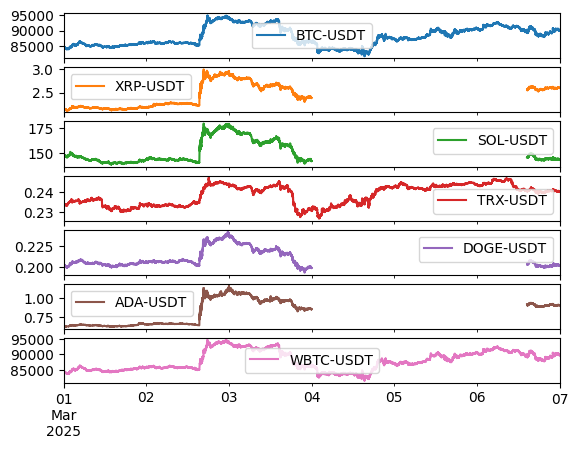

In [71]:
train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1).loc[dt.date(2025, 3, 1):dt.date(2025, 3, 7)].plot(subplots=True)

# Rolling Estimation: ADA-USDT, SOL-USDT 

See other notebook for full justification of how we go about selecting pairs. Note the complication of these "chunks" of missing data but we will come back to that. 

The basic problem: even if some series *were* cointegratd, most likely that they exhibit very weak levels of long-term mean reversion. If there is to be a mean-reversion based pairs trading strategy, it will be based on trading short-term mean-reversion patterns around a moving equilibrium. 

In [ ]:
train_midprice_df = train_midprice_df.drop(['ETH-USDT', 'BNB-USDT'], axis=1)

In [77]:
train_midprice_df[['ADA-USDT', 'SOL-USDT']].corr()

symbol,ADA-USDT,SOL-USDT
symbol,,
ADA-USDT,1.000000,0.845929
SOL-USDT,0.845929,1.000000


In [99]:
from itertools import permutations

PAIRS = list(permutations(train_midprice_df.columns, 2))
static_spreads_df = pd.DataFrame({
    f"{pair[0]}-{pair[1]}": fit_spread(x=train_midprice_df[pair[0]], y=train_midprice_df[pair[1]]) 
    for pair in PAIRS
})

hurst_ols_df = pd.DataFrame({
    col: nolds.mfhurst_b(static_spreads_df[col], qvals=[1, 2]) 
    for col in static_spreads_df
}, index=['q=1', 'q=2']).T
hurst_ols_df.sort_values(['q=1', 'q=2']).head(n=5)

,q=1,q=2
BTC-USDT-WBTC-USDT,0.198222,0.198901
WBTC-USDT-BTC-USDT,0.198408,0.199066
ADA-USDT-DOGE-USDT,0.475137,0.479084
DOGE-USDT-ADA-USDT,0.479913,0.481840
SOL-USDT-ADA-USDT,0.486822,0.487590


## Implementation 

Question - is there sufficient mean reversion to make a mean-reverting trading strategy profitable? 

I am interested in evaluating, **on the training data**, how a rolling OLS/Bol band trading strategy performs compares to say, a benchmark buy/hold strategy. 

Simplest backtesting approach: 
1. Optimise OLS on the first 6 months of data, then draw conclusions on the next 3 months of data 

More sophisticated: 
1. Walk-forward testing 
   1. Do out of sample testing in a "walk-forward" manner, then average across the out of sample periods 

I have a VERY simple goal: 
- Use the training data to evaluate whether trading on short-term mean reversion patterns is more profitable than a benchmark buy/hold strategy. 
- At the same time, I need to choose the parameters in the first place 

<Axes: >

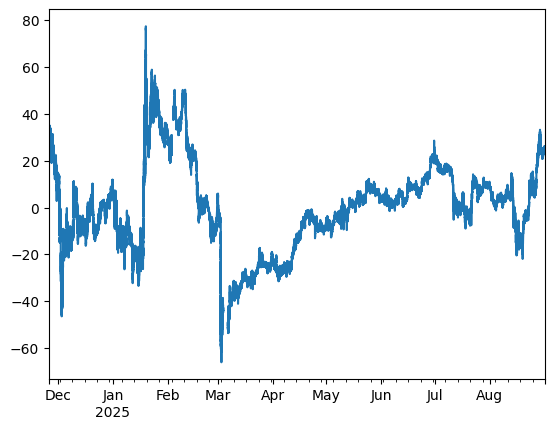

In [92]:
static_spreads_df['ADA-USDT-SOL-USDT'].plot()

In [ ]:
#look at rolling OLS correlation 

# Rolling OLS - Implementation 
- For now, just implement a *rolling OLS approach with FIXED parameters* and evaluate the relative performance of the trading strategy. 

In [ ]:
DAYS_IN_WEEK = 7 
HOURS_IN_DAYS = 24
MINUTES_PER_HOUR = 60 
TICKS_PER_MINUTE = 6

#Set lookback period to 1 week 
LOOKBACK_PERIOD = 7*DAYS_IN_WEEK*HOURS_IN_DAYS*MINUTES_PER_HOUR*TICKS_PER_MINUTE
BOLLINGER_BAND_LOOKBACK = 20 #for calculating MA, etc 

In [15]:
pairs_df = train_df[train_df['symbol'].isin(['ADA-USDT', 'SOL-USDT'])].pivot(columns = 'symbol', values = ['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size', 'mid_price'])

In [16]:
pairs_df

bid_0_price          ask_0_price          bid_0_size  \
symbol                 SOL-USDT ADA-USDT    SOL-USDT ADA-USDT   SOL-USDT   
origin_time                                                                
2024-11-26 00:00:00      233.87   0.9426      233.88   0.9427     50.141   
2024-11-26 00:00:10      234.33      NaN      234.34      NaN      0.023   
2024-11-26 00:00:20      234.21   0.9434      234.22   0.9435    102.100   
2024-11-26 00:00:30      234.14   0.9440      234.15   0.9441     51.115   
2024-11-26 00:00:50      233.90   0.9426      233.91   0.9427     57.078   
...                         ...      ...         ...      ...        ...   
2025-08-31 23:59:10      200.74   0.8115      200.75   0.8116    265.460   
2025-08-31 23:59:20      200.69   0.8114      200.70   0.8115     55.502   
2025-08-31 23:59:30      200.65   0.8112      200.66   0.8113    469.371   
2025-08-31 23:59:40      200.67   0.8113      200.68   0.8114    745.666   
2025-08-31 23:59:50      200.61   0.8112      200.62   0.8113    163.837   

                             ask_0_size          mid_price           
symbol              ADA-USDT   SOL-USDT ADA-USDT  SOL-USDT ADA-USDT  
origin_time                                                          
2024-11-26 00:00:00   4115.9     74.033   3701.5   233.875  0.94265  
2024-11-26 00:00:10      NaN     66.220      NaN   234.335      NaN  
2024-11-26 00:00:20   4616.5     22.076  10869.4   234.215  0.94345  
2024-11-26 00:00:30   1610.6     44.458   4015.1   234.145  0.94405  
2024-11-26 00:00:50   2290.9     60.073   1464.0   233.905  0.94265  
...                      ...        ...      ...       ...      ...  
2025-08-31 23:59:10    475.9    637.797  28070.2   200.745  0.81155  
2025-08-31 23:59:20  12368.5   1072.202  28927.1   200.695  0.81145  
2025-08-31 23:59:30  22515.2    254.517  13123.3   200.655  0.81125  
2025-08-31 23:59:40  18892.0      0.233  14171.8   200.675  0.81135  
2025-08-31 23:59:50  14904.0    455.079  24959.7   200.615  0.81125  

[2368947 rows x 10 columns]

In [ ]:
#To avoid lookahead bias, let's just start with the first 3 months of data and get a sense of how it performs 
sample_df = pairs_df[pairs_df.index <= dt.datetime(2025, 4, 1)]

In [ ]:
#Development phase: pricing 

# How to refine our OLS pricing signal and our trading strategy via cross-validation/other testing? 